# Quotes' initial analysis
This notebook conducts an initial analysis on the quotes, analysing the distributions of various aspects of the dataset. 
Let's first load the data:

In [4]:
import textstat as ts # pip install textstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

#load pickle
PICKLE_PATH = "../data/binary/us-politicians.pickle"
df = pd.read_pickle(PICKLE_PATH)
df.head()

,speaker_id,quote_id,quotation,speaker,party,Date-Time
0,1282411,2015-06-11-000090,25-year cost estimate for the U.S. nuclear mod...,Ed Markey,29552,2015-06-11
1,1282411,2015-08-11-090504,The state is transitioning to a higher percent...,Ed Markey,29552,2015-08-11
2,1282411,2015-10-27-125840,This highly coveted TIGER grant funding would ...,Ed Markey,29552,2015-10-27
3,1282411,2015-01-19-008025,carefully cutting the Gordian knot that has ti...,Ed Markey,29552,2015-01-19
4,1282411,2015-12-09-094134,The amendments would improve the safety of agi...,Ed Markey,29552,2015-12-09


Subsequently, we create the following new columns:
- Flesch reading ease: in the Flesch reading-ease test, higher scores indicate material that is easier to read;
lower numbers mark passages that are more difficult to read.
- Dale Chall readability score: different from other tests, since it uses a lookup table of the most commonly used 3000 English words.
It returns the grade level necessary to understand the sentence. Hence, the higher the score, the higher is the difficulty.
- Text Standard: based upon a combination of all the library's tests, returns the estimated school grade level required to understand the text.
- Reading time: returns the reading time of the given text. Assumes 14.69ms per character.

In [5]:
if not os.path.exists("../data/binary/us-politicians-complexity.pickle"):
    df['flesch_reading_ease']=df['quotation'].apply(lambda x : ts.flesch_reading_ease(x))
    df['dale_chall_readability_score']=df['quotation'].apply(lambda x : ts.dale_chall_readability_score_v2(x))
    df['text_standard']=df['quotation'].apply(lambda x : ts.text_standard(x,True))
    df['reading_time']=df['quotation'].apply(lambda x : ts.reading_time(x))
    # save to pickle
    df.to_pickle("../data/binary/us-politicians-complexity.pickle")
else:
    PICKLE_PATH = "../data/binary/us-politicians-complexity.pickle"
    df = pd.read_pickle(PICKLE_PATH)

In [24]:
df.head()

,speaker_id,quote_id,quotation,speaker,party,Date-Time,flesch_reading_ease,dale_chall_readability_score,text_standard,reading_time
0,1282411,2015-06-11-000090,25-year cost estimate for the U.S. nuclear mod...,Ed Markey,29552,2015-06-11,36.96,11.10,17.0,0.84
1,1282411,2015-08-11-090504,The state is transitioning to a higher percent...,Ed Markey,29552,2015-08-11,41.36,10.35,11.0,1.04
2,1282411,2015-10-27-125840,This highly coveted TIGER grant funding would ...,Ed Markey,29552,2015-10-27,34.43,10.64,24.0,6.14
3,1282411,2015-01-19-008025,carefully cutting the Gordian knot that has ti...,Ed Markey,29552,2015-01-19,25.80,11.73,16.0,1.73
4,1282411,2015-12-09-094134,The amendments would improve the safety of agi...,Ed Markey,29552,2015-12-09,0.76,11.33,0.0,4.39


We then split the DataFrame into two, one for Democrats and one for Republicans.  We take a random sample of Republicans
quotes, since they are significantly more  than Democrats' quotes, in order to have the same amount of sentences analyzed.
This way the representations are clearer but the result doesn't change.
Initially we plot the difference between the length of quotes, then we plot the difference of metrics' score
across all speakers and, subsequently, across all quotes from the two most popular ones: Donald Trump and Barack Obama.
Finally, we see if there are any variations over the years.

In [17]:
# To have a clearer visualization we take into consideration the same amount of quotations from both parties
democrats = df[df["party"] == 29552]
republicans = df[df["party"] == 29468].sample( democrats['quote_id'].count())

Let's examine if the number of quotes from the two parties is balanced. To do so, let's plot the distribution of the number of quotes per party across time:

In [22]:
def plot_across_time(democrats_across_time, republicans_across_time):
    # Change the date format and count number of quotes per month
    democrats_across_time["Date-Time"] = democrats_across_time["Date-Time"].dt.strftime('%Y-%m')
    republicans_across_time["Date-Time"] = republicans_across_time["Date-Time"].dt.strftime('%Y-%m')
    democrats_across_time = democrats_across_time.groupby(['Date-Time'], as_index=False).agg('count')
    republicans_across_time = republicans_across_time.groupby(['Date-Time'], as_index=False).agg('count')

    # Plot the obtained results
    fig, ax = plt.subplots()
    ax.bar(democrats_across_time['Date-Time'], democrats_across_time['count'], log=True, alpha=0.5, label="Democrats", align='center')
    ax.bar(republicans_across_time['Date-Time'], republicans_across_time['count'], log=True, alpha=0.5, label="Republicans", align='center')
    plt.xticks(np.arange(0, len(democrats_across_time['Date-Time']) + 1, 12))
    plt.show()

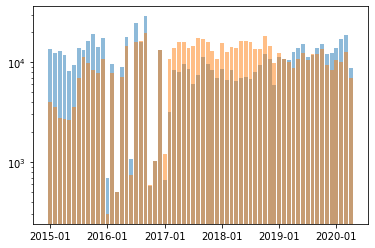

In [23]:
plot_across_time(democrats[["Date-Time","quote_id"]].rename(columns={'quote_id':'count'}), republicans[["Date-Time","quote_id"]].rename(columns={'quote_id':'count'}))

We can see that, despite a few low values in 2016, the distribution is rather regular, and the difference between the number of quotes of democrats and republicans across the year is not substantial enough to hinder our future analysis.

Now let's analyse the difference in the distribution of quotes' length of the two parties.

In [18]:

def plot_length(democrats, republicans):
    # Plot the distribution of quotes' length
    democrats_lengths = democrats["quotation"].apply(lambda x: len(x))
    republicans_lengths = republicans["quotation"].apply(lambda x: len(x))

    plt.hist(democrats_lengths, log=True, alpha=0.5, label="Democrats", bins = 100)
    plt.hist(republicans_lengths, log=True, alpha=0.5, label = "Republicans", bins = 100)
    plt.axvline(republicans_lengths.mean(), color = 'green', label = f"mean republicans: {np.round(republicans_lengths.mean(), 1)}")
    plt.axvline(democrats_lengths.mean(), color = 'blue', label = f"mean democrats: {np.round(democrats_lengths.mean(), 1)}")
    plt.axvline(republicans_lengths.median(), color = 'red', label = f"mean republicans: {np.round(republicans_lengths.median(), 1)}")
    plt.axvline(democrats_lengths.median(), color = 'yellow', label = f"mean democrats: {np.round(democrats_lengths.median(), 1)}")

    plt.title("Length of politicans' quotations.")
    plt.legend()
    plt.show()

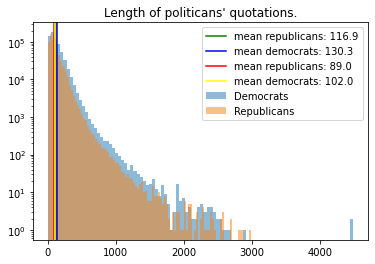

In [19]:
plot_length(democrats, republicans)

We see that the number of quotes decreases uniformly as their lenght increases, with a few outliers over the length 3000. Let's try removing them.

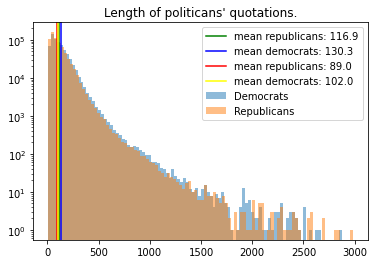

In [20]:
plot_length(democrats[democrats["quotation"].str.len()<3000], republicans[republicans["quotation"].str.len()<3000])

In [48]:
#plotting distribution, mean and median for both republicans and democrats, in the four calculated scores

def plot_metrics_scores(dem_data,rep_data, title):
    metrics_columns=['flesch_reading_ease','dale_chall_readability_score','text_standard','reading_time']
    fig, axs = plt.subplots(4, figsize = (10,15))
    fig.suptitle(title, fontsize=16)
    bins = np.logspace(0, np.log10(10**3), 50)

    axs[0].hist(dem_data['flesch_reading_ease'],log=True, alpha=0.5,bins=bins)
    axs[0].hist(rep_data['flesch_reading_ease'],log=True, alpha=0.5,bins=bins)
    axs[0].set_title("Flesch reading ease, higher is easier")
    axs[1].hist(dem_data['dale_chall_readability_score'],log=True, alpha=0.5,bins=bins)
    axs[1].hist(rep_data['dale_chall_readability_score'],log=True, alpha=0.5,bins=bins)
    axs[1].set_title("Dale Chall readability score, lower is easier")
    axs[2].hist(dem_data['text_standard'],log=True, alpha=0.5,bins=bins)
    axs[2].hist(rep_data['text_standard'],log=True, alpha=0.5,bins=bins)
    axs[2].set_title("Text Standard test score, lower is easier")
    axs[3].hist(dem_data['reading_time'],log=True, alpha=0.5,bins=bins)
    axs[3].hist(rep_data['reading_time'],log=True, alpha=0.5,bins=bins)
    axs[3].set_title("Reading time")
    metrics_rep = rep_data[metrics_columns]
    metrics_dem = dem_data[metrics_columns]
    mean_dem = metrics_dem.mean(axis = 0)
    median_dem = metrics_dem.median(axis = 0)
    mean_rep = metrics_rep.mean(axis = 0)
    median_rep = metrics_rep.median(axis = 0)

    for i,ax in enumerate(axs):
        ax.axvline(mean_rep[i], color = 'green', label = f"mean republicans: {np.round(mean_rep[i], 1)}")
        ax.axvline(mean_dem[i], color = 'blue', label = f"mean democrats: {np.round(mean_dem[i], 1)}")
        ax.axvline(median_rep[i], color = 'red', label = f"median republicans: {np.round(median_rep[i], 1)}")
        ax.axvline(median_dem[i], color = 'orange', label = f"median democrats: {np.round(median_dem[i], 1)}")
        ax.legend()
        ax.set_xscale('log')
    plt.show()

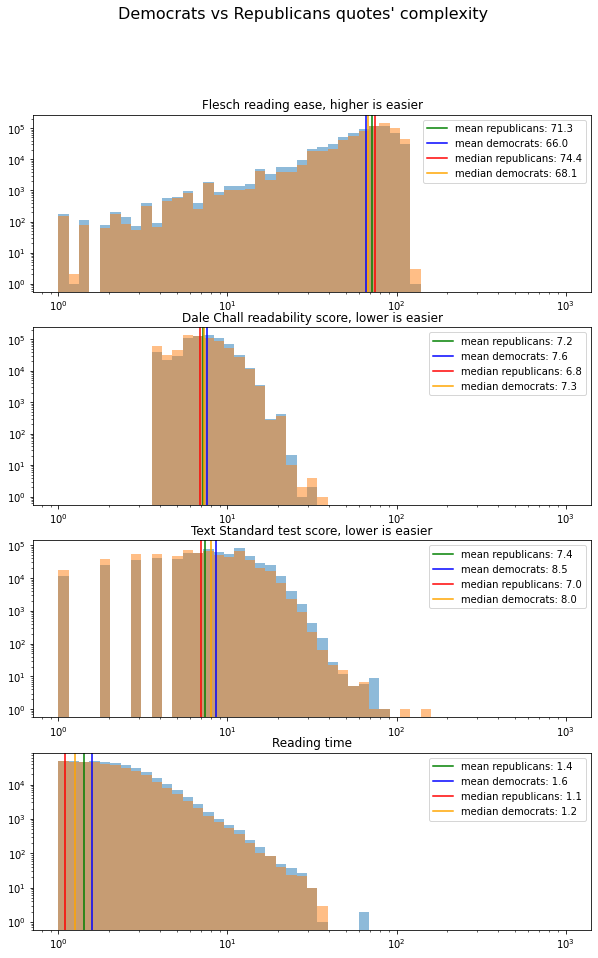

In [49]:
plot_metrics_scores(democrats,republicans,"Democrats vs Republicans quotes' complexity")

Let's find the most common speakers of each party

In [50]:
# ten most common speakers
pop_dem_speakers=democrats["speaker"].value_counts()[:10]
pop_rep_speakers=republicans["speaker"].value_counts()[:10]
print("Most common Democrat's speakers")
print(pop_dem_speakers)
print("\nMost common Republican's speakers")
print(pop_rep_speakers)

Most common Democrat's speakers
Barack Obama        156738
Hillary Clinton     100493
Joe Biden            58637
Nancy Pelosi         52222
Elizabeth Warren     48578
Andrew Cuomo         45714
John Kerry           28801
Pete Buttigieg       24619
Kamala Harris        21799
Bill Clinton         17443
Name: speaker, dtype: int64

Most common Republican's speakers
Donald Trump      510459
John McCain        21803
Rick Scott         16861
John Kasich        15384
Rudy Giuliani      14680
Ron DeSantis       10175
George W. Bush      9142
Mike Huckabee       8729
Newt Gingrich       8544
Rick Perry          8534
Name: speaker, dtype: int64


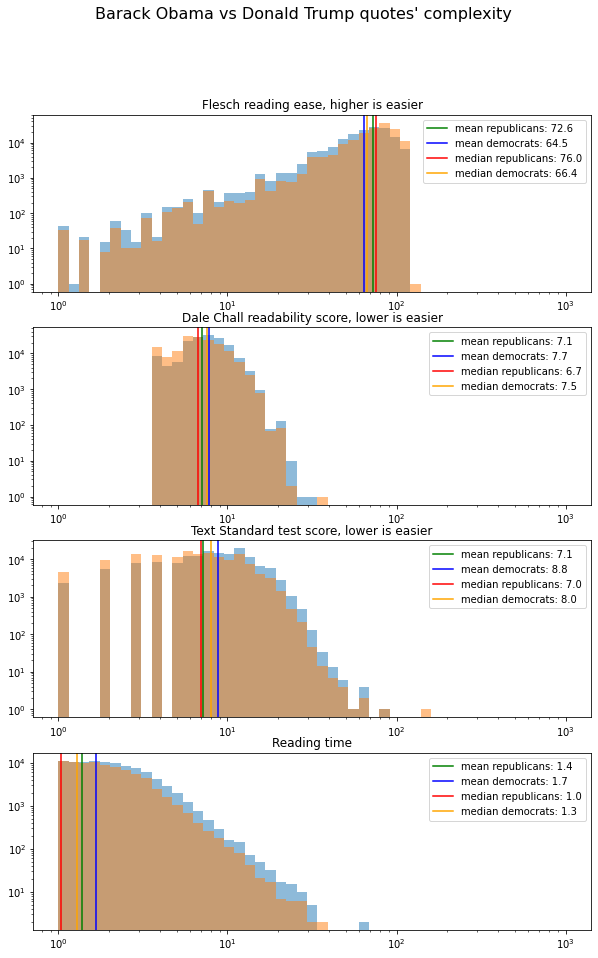

In [51]:
#repeating the plotting for the two most common speakers of the parties
# To have a clearer visualization we take into consideration the same amount of quotations from both parties
barack_obama = democrats[democrats['speaker']== 'Barack Obama']
donal_trump = republicans[republicans['speaker']== 'Donald Trump']
donal_trump = donal_trump.sample( barack_obama['quote_id'].count())
plot_metrics_scores(barack_obama,donal_trump, "Barack Obama vs Donald Trump quotes' complexity")

In [52]:
years = [2015,2016,2017,2018,2019,2020]
for year in years:
    year_df_rep = republicans[republicans['Date-Time'] <= f"{year}-1-31"]
    year_df_rep = republicans[republicans['Date-Time'] >= f"{year}-1-1"]
    year_df_dem = democrats[democrats['Date-Time'] <= f"{year}-1-31"]
    year_df_dem = democrats[democrats['Date-Time'] >= f"{year}-1-1"]
    print(f"\n{year}\n")
    for metric in metrics_columns:
        print(f"{metric} for democrats: " + str(year_df_dem[metric].mean()))
        print(f"{metric} for republicans: " + str(year_df_rep[metric].mean()))


2015

flesch_reading_ease for democrats: 66.01516964500254
flesch_reading_ease for republicans: 71.34398664301942
dale_chall_readability_score for democrats: 7.58003176801464
dale_chall_readability_score for republicans: 7.160928005246786
text_standard for democrats: 8.535138861937776
text_standard for republicans: 7.404666560822293
reading_time for democrats: 1.5902663750057766
reading_time for republicans: 1.4235666466731431

2016

flesch_reading_ease for democrats: 66.45330043962555
flesch_reading_ease for republicans: 71.05237135006158
dale_chall_readability_score for democrats: 7.53126088224044
dale_chall_readability_score for republicans: 7.19236966691623
text_standard for democrats: 8.45844909843203
text_standard for republicans: 7.446727337233191
reading_time for democrats: 1.5783873527548364
reading_time for republicans: 1.4204618113705962

2017

flesch_reading_ease for democrats: 66.55346066772445
flesch_reading_ease for republicans: 70.55072607928814
dale_chall_readability_

This is just an initial and superficial analysis, but it clearly seems to suggest that there's a difference, not even so slight, between the two parties.
In particular, Republicans' quotes have always shown a lower complexity score.